# Engine Sizing
The followign overview gives an overview of sizing te engine given a certain thrust target and OF ratio.

In [62]:
# general
import os
import numpy as np
import pandas as pd

# thermo
import cantera as ct

# numerical methods
import scipy.optimize

# visualization / other
import matplotlib.pyplot as plt

In [63]:
plotfolder = "engineplots/"
filefolder = "enginefiles/"

# create appropriate folders if they don't exist
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

if not os.path.exists(filefolder):
    os.mkdir(filefolder)

### Main parameter definitions

In [64]:
P0 = 2.758e+6 # First Chamber (Stagnation) Pressure Guess [Pa]
P_amb = 80325 # Ambient Pressure [Pa] - optimal operating pressure
Ti = 300      # First Chamber Inlet Temperature Guess [K]
OF = 10.2     # OF ratio used
thrust = 4448.22 # Tqrget thrust [N]

In [65]:
# Define gas
gas = ct.Solution('gri30.yaml')          
mixture = "C2H6:1, N2O:{}".format(OF)    # define mixture via mixture string
gas.TPY = Ti, P0, mixture              # define state of gas before chemical balance
gas.equilibrate("HP")                  # equilibrate keeping enthalpy and pressure constant

# Extract Preliminary Gas Properties
h0 = gas.h  # gas enthalpy [J]
T0 = gas.T  # stagnation temperature [K]
kc = gas.cp / gas.cv # specific heat ratio in chamber
MW = gas.mean_molecular_weight / 1000.0 # average molecular weight of gas [kg / mol] (function returns [g / mol])
R = (ct.gas_constant / 1000.0) / MW # Specfic gas constant of exhaust gases [J / kg K] (ct.gas_constant returns [J / kmol K])
V0 = gas.v # specific volume in chamber [m^3 / kg] (from ideal gas equation)

# Print Properties
print("Enthalpy:", h0, "[J]\nStagnation temperature:", T0, "[K]\nSpecific heat ratio:", kc, "[-]\nMean molecular weight:", MW, "[kg/mol]", "\nSpecific gas constant:", R, "[J/kg K]", "\nSpecific volume:", V0, "[m^3/kg]")

Enthalpy: 1441245.9601456434 [J]
Stagnation temperature: 3281.188239511196 [K]
Specific heat ratio: 1.2405024045277944 [-]
Mean molecular weight: 0.02620354167025899 [kg/mol] 
Specific gas constant: 317.3030089894356 [J/kg K] 
Specific volume: 0.3774948881282275 [m^3/kg]


## Engine Sizing
The main parameters for the engine to be sized are the throat area $A_t$ and the exit area $A_e$. The following sizing procedure uses the equation for thrust <em>(equation nr. 28 from equation sheet)</em> $F = \dot{m} c^* C_F$, where $c^*(k)$ is taken to be a constant (i.e. specific heat ratio - k is assumed to be constant throughout the thrust chamber) and $C_F(k, P_{amb})$ is also taken to be a sort of constant to relate $\dot{m}$ to $F$. From this we find $\dot{m}$.<br>
Then we use $P_0 A_t = \dot{m} c^*$ <em>(equation nr. 25 from equation sheet)</em>, to find $A_t$ .


### Finding Throat Area $A_t$

In [66]:
# Defining equations for characteristic velocity and thrust coefficient 
def get_c_star(k, R, T0):
    return np.sqrt(k * R * T0) / (k * np.sqrt( (2 / (k + 1))**((k + 1)/(k - 1)) ) )
# k = specific heat ratio, R = specific gas constant, T0 = stagnation temperature

def get_C_F(k, R, T0, P_amb, P0):
    return np.sqrt(2 * k ** 2 / (k - 1) * (2 / (k + 1)) ** ((k + 1) / (k - 1)) * (1 - (P_amb / P0) ** ((k - 1) / k)))
# k = specific heat ratio, R = specific gas constant, T0 = stagnation temperature, P_amb = exit pressure, P0 = stagnation pressure

In [67]:
# Find characteristic velocity, thrust coefficient, and mass flow rate
c_star = get_c_star(kc, R, T0)
C_F = get_C_F(kc, R, T0, P_amb, P0)
mdot = thrust / (c_star * C_F)

print("Characteristic velocity:", c_star, "[m/s]\nThrust coefficient:", C_F, "[-]", "\nMass flow rate:", mdot, "[kg/s]")


Characteristic velocity: 1554.759568630687 [m/s]
Thrust coefficient: 1.484814244909338 [-] 
Mass flow rate: 1.9268632542653232 [kg/s]


In [68]:
# Find throat area
A_t = mdot * c_star / (P0)

# print throat area
print("Throat area:", A_t * 10000, "[cm^2]")

Throat area: 10.862251928977068 [cm^2]


### Finding Exit Area $A_e$

In [69]:
""" Currently Placeholder """

' Currently Placeholder '

### Determining Other Operation Parameters
From the previous values we can obtain other operation parameters, such as specific impulse $I_{sp} = \frac{C_F * C^*}{g}$

In [70]:
Isp = C_F * c_star / 9.81
print("Specific impulse:", Isp, "[s]")

Specific impulse: 235.32407287583501 [s]


### Retrieving Chamber Geometry
Using the throat area $A_t$ and geometry parameters such as:
- $\alpha$ - divergence half angle
- $\beta$ - convergence half angle
- $Dc$ - chamber diameter

as well as theoretical parameters such as:

- $L^*$ - characteristic length

The chamber geometry retireving currently doesn't involve finding exit area, so we will use a manually set a total length $L_{tot}$, which will set a $divergence length $L_{div}$ - the axial lenght of the diverging section.

In [71]:
alpha = 15 # nozzle divergence half angle [deg]
beta =  30 # nozzle convergence half angle [deg]
D_c = 0.127 # chamber diameter [m]
L_star = 3 # characteristic length [m]
L_tot = 0.4 # divergence length [m]


In [72]:
# Calculate additional dimensional parameters
V_c = A_t * L_star # chamber volume [m^3]
A_c = np.pi * D_c ** 2 / 4 # chamber area [m^2]
D_t = np.sqrt(4 * A_t / np.pi) # throat diameter [m]

L_conv = (D_c - D_t) / 2 / np.tan(np.radians(beta)) # converging length [m]
L_cyl = V_c / A_c - L_conv * (1 + np.sqrt(A_t / A_c) + A_t / A_c) # cylindrical chamber length [m] (from equation 32 in equation sheet)
L_div = L_tot - L_conv - L_cyl # divergence length [m]

D_e = D_t + 2 * L_div * np.tan(np.radians(alpha)) # exit diameter [m]

# check if diameter dimension is physically possible
if(D_c - D_t < 0):
    print("Diameter dimension is not physically possible. Chamber diameter is by {} m smaller than throat diameter.".format(D_c - D_t))

# print dimensional parameters
print("Chamber volume:", V_c * 1e6, "[cm^3]\nChamber area:", A_c * 1e4, "[cm^2]\nThroat diameter:", D_t * 1e2, "[cm]\nConverging length:", L_conv * 1e2, "[cm]\nCylindrical chamber length:", L_cyl * 1e2, "[cm]", "\nDiverging length:", L_div * 1e2, "[cm]", "\nExit diameter:", D_e * 1e2, "[cm]")

Chamber volume: 3258.6755786931203 [cm^3]
Chamber area: 126.67686977437444 [cm^2]
Throat diameter: 3.7189042338905964 [cm]
Converging length: 7.777857087271609 [cm]
Cylindrical chamber length: 15.001956110025628 [cm] 
Diverging length: 17.220186802702763 [cm] 
Exit diameter: 12.947174528485162 [cm]


In [73]:
# Manually extracting geometry as a function of axial position r(x)
x = list()
r = list()

# first position - chamber start (injector plate)
x.append(0) 
r.append(D_c / 2) 

# second position - chamber end (converging section start)
x.append(L_cyl) 
r.append(D_c / 2) 

# third position - throat
x.append(L_cyl + L_conv)
r.append(D_t / 2)

# fourth position - diverging section end
x.append(L_cyl + L_conv + L_div)
r.append(D_e / 2)

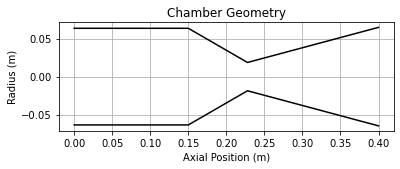

In [74]:
# plot result
fig, axs = plt.subplots()
fig.set_facecolor('white')
axs.plot(x, r, color = "k") # upper innner wall
axs.plot(x, -np.array(r), color = "k") # lower inner wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Chamber Geometry")
axs.set_aspect('equal')
plt.savefig(plotfolder + "enginegeometry.png", dpi=300)

In general, to size the engine (as was mentionned previously), the main parameters to find are the throat area $A_t$ and the exit area $A_e$. Therefore we must find some way to relate the thermodynamic properties of the gas to the cross sectional area at some axial position of the thrust chamber. <br>

For this we use mass flow conservation $\dot{m} = \frac{Av}{V}$ that gives $A = \frac{\dot{m} V}{v}$, where $v$ - gas velocity, and $V$ - specific volume. 

To determine velocity we can use enthalpy conservation: $v_x = \sqrt{2(h_0 - h_x)}$, where $h_0$ - stagnation enthalpy.

To determine specific volume we can use isentropic flow equations $V_x = V_0 (\frac{p_0}{p_x})^{\frac{1}{k}}$, where $p_0$ - stagnation pressure, and $k$ - specific heat ratio. Here the subscript $x$ denotes some axial position. 

Knowing both $v$ and $V$ at some axial position $x$, we can determine the necessary cross sectional area there $A_x$ <br>

<em>Note: Currently we assume the specific heat ratio $k$ to be constant throughout the thrust chamber.</em>

### Constraints
But to even be able to use the equations above, we must have some constraints on the properties of the gas at the axial positions in question. For our postions of interest these constraints are:
- for throat: $M = 1$
- for exit: $P = P_{amb}$

With these constraints (and with isentropic flow) we can determine the state of the gas and therefore $v$ and $V$, which give (knowing $\dot{m}$) $A$.

### Find Exhaust Gas Chamber (Stagnation) Properties

In [75]:
# Define gas
gas = ct.Solution('gri30.yaml')          
mixture = "C2H6:1, N2O:{}".format(OF)    # define mixture via mixture string
gas.TPY = Ti, P0, mixture              # define state of gas before chemical balance
gas.equilibrate("HP")                  # equilibrate keeping enthalpy and pressure constant

# Extract Preliminary Gas Properties
h0 = gas.h  # gas enthalpy [J]
s0 = gas.s  # gas entropy [J/K]
T0 = gas.T  # stagnation temperature [K]
kc = gas.cp / gas.cv # specific heat ratio in chamber
MW = gas.mean_molecular_weight / 1000.0 # average molecular weight of gas [kg / mol] (function returns [g / mol])
R = (ct.gas_constant / 1000.0) / MW # Specfic gas constant of exhaust gases [J / kg K] (ct.gas_constant returns [J / kmol K])
V0 = gas.v # specific volume in chamber [m^3 / kg] (from ideal gas equation)

# Print Properties
print("Enthalpy:", h0, "[J]\nStagnation temperature:", T0, "[K]\nSpecific heat ratio:", kc, "[-]\nMean molecular weight:", MW, "[kg/mol]", "\nSpecific gas constant:", R, "[J/kg K]", "\nSpecific volume:", V0, "[m^3/kg]")

Enthalpy: 1441245.9601456434 [J]
Stagnation temperature: 3281.188239511196 [K]
Specific heat ratio: 1.2405024045277944 [-]
Mean molecular weight: 0.02620354167025899 [kg/mol] 
Specific gas constant: 317.3030089894356 [J/kg K] 
Specific volume: 0.3774948881282275 [m^3/kg]


### Determine Gas Throat Properties
The main constraint for the throat properties are that the Mach number $M = 1$. From this we can determine the throat static pressure. Assuming $k = const.$ it is $P_t = P_0 (1 + \frac{k-1}{2})^{\frac{-k}{k-1}}$

In [76]:
P_t = P0 * (1 + (kc - 1) / 2) ** (-kc / (kc - 1))  # throat pressure [Pa] (constraint equivalent)

# Model gas at constraint conditions
gas.SP = s0, P_t # use insentropic expansion and constraint pressure to find state at throat (note - we don't equilibrate again - we assume frozen flow)
h_t = gas.h # throat enthalpy [J]

v_t = np.sqrt(2 * (h0 - h_t))
V_t = gas.v # throat specific volume [m^3 / kg]

# find throat area
A_t = mdot * V_t / v_t # throat area [m^2]


print("Throat area:", A_t * 10000, "[cm^2]")
print("Throat pressure:", P_t / 6894.76, "[psi]")

Throat area: 10.857149859940145 [cm^2]
Throat pressure: 222.6937476636665 [psi]


### Determine Gas Exit Properties
The main constraint for the exit properties are that the gas exit pressure $P = P_{amb}$. 

In [77]:
# Model gas at constraint conditions
gas.SP = s0, P_amb # use insentropic expansion and constraint pressure to find state at exit (note - we don't equilibrate again - we assume frozen flow)
h_e = gas.h # exit enthalpy [J]

v_e = np.sqrt(2 * (h0 - h_e))
V_e = gas.v # exit specific volume [m^3 / kg]

# find exit area
A_e = mdot * V_e / v_e # exit area [m^2]

# find expansion ratio
exp_ratio = A_e / A_t

print("Exit area:", A_e * 10000, "[cm^2]", "\nExpansion ratio:", exp_ratio, "[-]")

Exit area: 53.235371059495655 [cm^2] 
Expansion ratio: 4.903254698170772 [-]


### Retrieving Chamber Geometry
Using the parameters defined above, we can once again retrieve the chamber geometry.

In [78]:
# Calculate additional dimensional parameters
V_c = A_t * L_star # chamber volume [m^3]
A_c = np.pi * D_c ** 2 / 4 # chamber area [m^2]
D_t = np.sqrt(4 * A_t / np.pi) # throat diameter [m]

L_conv = (D_c - D_t) / 2 / np.tan(np.radians(beta)) # converging length [m]
L_cyl = V_c / A_c - L_conv * (1 + np.sqrt(A_t / A_c) + A_t / A_c) # cylindrical chamber length [m] (from equation 32 in equation sheet)

D_e = np.sqrt(4 * A_e / np.pi) # exit diameter [m]
L_div = (D_e - D_t) / 2 / np.tan(np.radians(alpha)) # divergence length [m]

# check if diameter dimension is physically possible
if(D_c - D_t < 0):
    print("Diameter dimension is not physically possible. Chamber diameter is by {} m smaller than throat diameter.".format(D_c - D_t))

# print dimensional parameters
print("Chamber volume:", V_c * 1e6, "[cm^3]\nChamber area:", A_c * 1e4, "[cm^2]\nThroat diameter:", D_t * 1e2, "[cm]\nConverging length:", L_conv * 1e2, "[cm]\nCylindrical chamber length:", L_cyl * 1e2, "[cm]", "\nDiverging length:", L_div * 1e2, "[cm]", "\nExit diameter:", D_e * 1e2, "[cm]")

Chamber volume: 3257.1449579820437 [cm^3]
Chamber area: 126.67686977437444 [cm^2]
Throat diameter: 3.718030734783082 [cm]
Converging length: 7.778613559688901 [cm]
Cylindrical chamber length: 14.989678683955814 [cm] 
Diverging length: 8.424944288533503 [cm] 
Exit diameter: 8.232944771562584 [cm]


In [79]:
# Manually extracting geometry as a function of axial position r(x)
x_can = list()
r_can = list()

# first position - chamber start (injector plate)
x_can.append(0) 
r_can.append(D_c / 2) 

# second position - chamber end (converging section start)
x_can.append(L_cyl) 
r_can.append(D_c / 2) 

# third position - throat
x_can.append(L_cyl + L_conv)
r_can.append(D_t / 2)

# fourth position - diverging section end
x_can.append(L_cyl + L_conv + L_div)
r_can.append(D_e / 2)

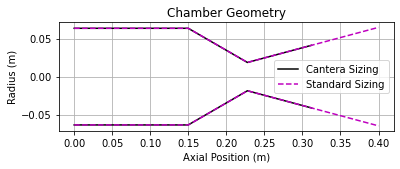

In [80]:
# plot result
fig, axs = plt.subplots()
fig.set_facecolor('white')
axs.plot(x_can, r_can, color = "k", label = "Cantera Sizing") # upper innner wall
axs.plot(x_can, -np.array(r_can), color = "k") # lower inner wall
axs.plot(x, r, color = "m", linestyle = "--", label = "Standard Sizing") # upper innner wall
axs.plot(x, -np.array(r), color = "m", linestyle = "--") # lower inner wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Chamber Geometry")
axs.set_aspect('equal')
plt.legend()
plt.savefig(plotfolder + "canteraenginegeometry.png", dpi=300)

## Using Cantera Cantera with Convergence
The following method to size the engine is virtually identical to the Cantera Sizing Method, only it takes into account the fact that the specific heat ratio at the throat $k_t$ is different from that at the chamber $k_c$.

### Find Exhaust Gas Chamber (Stagnation) Properties

In [81]:
# Define gas
gas = ct.Solution('gri30.yaml')          
mixture = "C2H6:1, N2O:{}".format(OF)    # define mixture via mixture string
gas.TPY = Ti, P0, mixture              # define state of gas before chemical balance
gas.equilibrate("HP")                  # equilibrate keeping enthalpy and pressure constant

# Extract Preliminary Gas Properties
h0 = gas.h  # gas enthalpy [J]
s0 = gas.s  # gas entropy [J/K]
T0 = gas.T  # stagnation temperature [K]
kc = gas.cp / gas.cv # specific heat ratio in chamber
MW = gas.mean_molecular_weight / 1000.0 # average molecular weight of gas [kg / mol] (function returns [g / mol])
R = (ct.gas_constant / 1000.0) / MW # Specfic gas constant of exhaust gases [J / kg K] (ct.gas_constant returns [J / kmol K])
V0 = gas.v # specific volume in chamber [m^3 / kg] (from cantera)

# Print Properties
print("Enthalpy:", h0, "[J]\nStagnation temperature:", T0, "[K]\nSpecific heat ratio:", kc, "[-]\nMean molecular weight:", MW, "[kg/mol]", "\nSpecific gas constant:", R, "[J/kg K]", "\nSpecific volume:", V0, "[m^3/kg]")

Enthalpy: 1441245.9601456434 [J]
Stagnation temperature: 3281.188239511196 [K]
Specific heat ratio: 1.2405024045277944 [-]
Mean molecular weight: 0.02620354167025899 [kg/mol] 
Specific gas constant: 317.3030089894356 [J/kg K] 
Specific volume: 0.3774948881282275 [m^3/kg]


### Determine Gas Throat Properties
To determine the gas throat properties we use the determined throat pressure from the equation $P_t = P_0 (1 + \frac{k-1}{2})^{\frac{-k}{k-1}}$ as an inital guess.<br>

Because the specific heat ratio at the throat $k_t$ is different from that at the chamebr $k_c$ and because local sonic velocity $v_s = \sqrt{kRT}$ is a function of $k$ and $T$, there will be some error between the velocity at the throat $v_t$ and the local sonic velocity $v_s$. This means that mMach number at the throat $M_t = \frac{v_t}{v_s}$ will not be equal to 1, which is a requirement. <br>

We can, however, converge to a throat pressure (and therefore gas state given by Cantera) that does satisfy $M_t = 1$.<br>

<em>Note: During the numerical solving (using scipy) we also iterate through different gas states and therefore also retrieve an "optimized" gas state at the throat.</em>


In [82]:
# find initial guess of throat pressure
P_t = P0 * (1 + (kc - 1) / 2) ** (-kc / (kc - 1))  # throat pressure [Pa] (constraint equivalent)

# define error function to iterate and get "imperfect gas" throat conditions - assume frozen flow
def throat_error(P_t):
    gas.SP = s0, P_t      
    k_t = gas.cp/gas.cv
    R = gas.cp * (1 - 1 / k_t)
    v_t = np.sqrt(2 * (h0 - gas.h) )                # Definition of stagnation enthalpy
    error = v_t - np.sqrt(k_t * R * gas.T)        # Difference between actual and sonic velocity - must be zero at throat
    return error # the error is the difference between the sonic and exhaust gas velocity

# use scipy's solver to minimize error function and model gas at constraint conditions
P_t = scipy.optimize.fsolve(throat_error, x0 = P_t) # function returns optimized pressure at throat [Pa]
h_t = gas.h # throat enthalpy [J]
k_t = gas.cp / gas.cv # throat specific heat ratio [-]
V_t = gas.v # throat specific volume [m^3 / kg] (retrieve from Cantera)
v_t = np.sqrt(2 * (h0 - h_t))

# find throat area
A_t = mdot * V_t / v_t # throat area [m^2]

print("Throat area:", A_t * 10000, "[cm^2]")

Throat area: 10.857139806982289 [cm^2]


### Determine Gas Exit Properties
The main constraint for the exit properties are that the gas exit pressure $P = P_{amb}$.

<em>Note: Now we continue to use the "optimized" gas state at the throat.</em>

In [83]:
# Model gas at constraint conditions
gas.SP = s0, P_amb # use insentropic expansion and constraint pressure to find state at exit (note - we don't equilibrate again - we assume frozen flow)
h_e = gas.h # exit enthalpy [J]

v_e = np.sqrt(2 * (h0 - h_e))
V_e = gas.v # exit specific volume [m^3 / kg]

# find exit area
A_e = mdot * V_e / v_e # exit area [m^2]

# find expansion ratio
exp_ratio = A_e / A_t

print("Exit area:", A_e * 10000, "[cm^2]", "\nExpansion ratio:", exp_ratio, "[-]")

Exit area: 53.235370982499084 [cm^2] 
Expansion ratio: 4.903259231152491 [-]


### Retrieving Chamber Geometry
Using the parameters defined above, we can once again retrieve the chamber geometry.

In [84]:
# Calculate additional dimensional parameters
V_c = A_t * L_star # chamber volume [m^3]
A_c = np.pi * D_c ** 2 / 4 # chamber area [m^2]
D_t = np.sqrt(4 * A_t / np.pi) # throat diameter [m]

# retrieving special axial positions for later use
x_c = L_cyl # chamber end axial position [m]
x_t = L_cyl + L_conv # throat axial position [m]

L_conv = (D_c - D_t) / 2 / np.tan(np.radians(beta)) # converging length [m]
L_cyl = V_c / A_c - L_conv * (1 + np.sqrt(A_t / A_c) + A_t / A_c) # cylindrical chamber length [m] (from equation 32 in equation sheet)

D_e = np.sqrt(4 * A_e / np.pi) # exit diameter [m]
L_div = (D_e - D_t) / 2 / np.tan(np.radians(alpha)) # divergence length [m]

# check if diameter dimension is physically possible
if(D_c - D_t < 0):
    print("Diameter dimension is not physically possible. Chamber diameter is by {} m smaller than throat diameter.".format(D_c - D_t))

# print dimensional parameters
print("Chamber volume:", V_c * 1e6, "[cm^3]\nChamber area:", A_c * 1e4, "[cm^2]\nThroat diameter:", D_t * 1e2, "[cm]\nConverging length:", L_conv * 1e2, "[cm]\nCylindrical chamber length:", L_cyl * 1e2, "[cm]", "\nDiverging length:", L_div * 1e2, "[cm]", "\nExit diameter:", D_e * 1e2, "[cm]")

Chamber volume: 3257.141942094687 [cm^3]
Chamber area: 126.67686977437444 [cm^2]
Throat diameter: 3.7180290134650837 [cm]
Converging length: 7.778615050394014 [cm]
Cylindrical chamber length: 14.98965449294315 [cm] 
Diverging length: 8.424947489446621 [cm] 
Exit diameter: 8.232944765608757 [cm]


In [85]:
# Manually extracting geometry as a function of axial position r(x)
x_can_c = list()
r_can_c = list()

# first position - chamber start (injector plate)
x_can_c.append(0) 
r_can_c.append(D_c / 2) 

# second position - chamber end (converging section start)
x_can_c.append(L_cyl) 
r_can_c.append(D_c / 2) 

# third position - throat
x_can_c.append(L_cyl + L_conv)
r_can_c.append(D_t / 2)

# fourth position - diverging section end
x_can_c.append(L_cyl + L_conv + L_div)
r_can_c.append(D_e / 2)

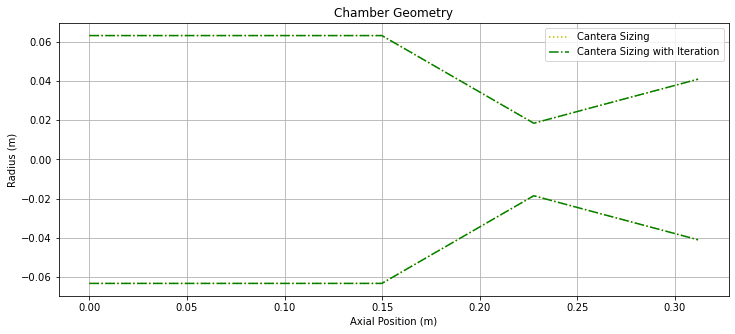

In [86]:
# plot result
fig, axs = plt.subplots(figsize = (12, 6))
fig.set_facecolor('white')
axs.plot(x_can, r_can, color = "y", linestyle = ":", label = "Cantera Sizing") # upper innner wall
axs.plot(x_can, -np.array(r_can), linestyle = ":", color = "y") # lower inner wall
#axs.plot(x, r, color = "m", linestyle = "--", label = "Standard Sizing") # upper innner wall
#axs.plot(x, -np.array(r), color = "m", linestyle = "--") # lower inner wall
axs.plot(x_can_c, r_can_c, color = "g", linestyle = "-.", label = "Cantera Sizing with Iteration") # upper innner wall
axs.plot(x_can_c, -np.array(r_can_c), color = "g", linestyle = "-.") # lower inner wall
axs.grid()
axs.set_xlabel("Axial Position (m)")
axs.set_ylabel("Radius (m)")
axs.set_title("Chamber Geometry")
axs.set_aspect('equal')
plt.legend()
plt.savefig(plotfolder + "canteraenginegeometry.png", dpi=300)

### Determining Other Useful Parameters

In [87]:
o_mdot = mdot * OF / (OF + 1) # oxidizer mass flow rate [kg/s]
f_mdot = mdot / (OF + 1) # fuel mass flow rate [kg/s]
print("Oxidizer mass flow rate:", o_mdot, "[kg/s]\nFuel mass flow rate:", f_mdot, "[kg/s]")

Oxidizer mass flow rate: 1.754821892277348 [kg/s]
Fuel mass flow rate: 0.1720413619879753 [kg/s]


## Saving Geometry Data
Save Obtained Engine Geometry Data.<br>

<em>Note: In the future this section could also be used to push the main obtained engine parameters to an excel sheet.</em>

In [88]:
# save geometry results to csv
dfgeom = pd.DataFrame({"x [m]": x_can_c, "r [m]": r_can_c}) # create dataframe with results

# save parameters to csv
dfgeomparams = pd.DataFrame({"alpha [deg]": [alpha], "beta [deg]": [beta], "D_c [m]": [D_c], "x_t [m]": [x_t], "x_c [m]": [x_c], "A_t [m^2]": [A_t], "A_e [m^2]": [A_e], "A_c [m^2]": [A_c]}) # create dataframe with results

# save mass flow results to csv
dfmass = pd.DataFrame({"OF used [-]" : [OF], "mdot [kg/s]": [mdot], "o_mdot [kg/s]": [o_mdot], "f_mdot [kg/s]": [f_mdot]}) # create dataframe with results

# save dataframe to csv
dfgeom.to_csv(filefolder + "enginegeometry.csv", index = False) # save dataframe to csv
dfmass.to_csv(filefolder + "enginemassflow.csv", index = False) # save dataframe to csv
dfgeomparams.to_csv(filefolder + "engineparameters.csv", index = False) # save dataframe to csv

## Compare Obtained Exit Area
The following section is meant to compare the obtained expansion area $A_e$ with results from other alternative methods.

### Expansion Ratio Equation

The first method of comparison is to use the equation $\epsilon = \frac{A_e}{A_t} = (\frac{k-1}{2})^{\frac{1}{2}} (\frac{2}{k+1})^{\frac{k+1}{2(k-1)}} (\frac{P_{amb}}{P_0})^{\frac{-1}{k}} [1-(\frac{P_{amb}}{P_0})^{\frac{k-1}{k}}]^{\frac{-1}{2}}$ to calculate the expansion ratio.

In [89]:
# calculate expansion ratio from lare equation
exp_ratio_calc = ((k_t - 1) / 2)**(1/2) * (2 / (k_t + 1)) ** ((k_t + 1) / (2 * (k_t - 1))) * (P_amb / P0) ** (-1 / k_t) * (1 - (P_amb / P0) ** ((k_t - 1) / k_t)) ** (-1 / 2)

# find exit area from expansion ratio
A_e_form = exp_ratio_calc * A_t # exit area [m^2]

# find difference between obtained values and formula obtained values
diffA_e = A_e - A_e_form # [m^2]
diff_exp_ratio = exp_ratio - exp_ratio_calc  # [-]

print("Calculated Exit area:", A_e * 10000, "[cm^2]", "\nCalculated Expansion ratio:", exp_ratio, "[-]", "\nDifference between Exit areas:", diffA_e * 10000, "[cm^2]", "\nDifference between expansion ratios:", diff_exp_ratio, "[-]")

Calculated Exit area: 53.235370982499084 [cm^2] 
Calculated Expansion ratio: 4.903259231152491 [-] 
Difference between Exit areas: -0.9980895889453654 [cm^2] 
Difference between expansion ratios: -0.09192933007121162 [-]


### Expansion Ratio Equation from ROP
Another equation we can use is the relation between cross sectional areas and Mach numbers: $\frac{A_e}{A_t}=\frac{1}{M_e}\sqrt{(\frac{(1+(\frac{k-1}{2})M_e^2)}{1+\frac{k-1}{2}})^{\frac{k+1}{k-1}}}$, where we have used the fact that the Mach number at the throat $M_t = 1$. For the exit Mach number we use the effective exhaust velocity $c$.

In [90]:
c = thrust / mdot # effective exhaust velocity [m/s]
M_e_calc2 = c / gas.sound_speed # exit Mach number [-]

# find expansion area ratio
exp_ratio_calc2 = 1 / M_e_calc2 * np.sqrt(((1 + ((k_t - 1) / 2) * M_e_calc2 ** 2) / (1 + (k_t - 1) / 2)) ** ((k_t + 1) / (k_t - 1)))

# find exit area from expansion ratio
A_e_calc2 = exp_ratio_calc2 * A_t # exit area [m^2]

# find difference between obtained values and formula obtained values
diffA_e = A_e - A_e_calc2 # [m^2]
diff_exp_ratio = exp_ratio - exp_ratio_calc2  # [-]

print("Exit Mach number:", M_e_calc2)
print("Calculated Exit area:", A_e_calc2 * 10000, "[cm^2]", "\nCalculated Expansion ratio:", exp_ratio_calc2, "[-]", "\nDifference between Exit areas:", diffA_e * 10000, "[cm^2]", "\nDifference between expansion ratios:", diff_exp_ratio, "[-]")

Exit Mach number: 2.8679944904629626
Calculated Exit area: 54.51130239098002 [cm^2] 
Calculated Expansion ratio: 5.02077926231764 [-] 
Difference between Exit areas: -1.2759314084809323 [cm^2] 
Difference between expansion ratios: -0.11752003116514853 [-]


### Expansion Ratio Equation from ROP using different exhaust velocity
Changing the equation for exhaust velocity to $v_2 = \sqrt{\frac{2k}{k-1}R}$

In [91]:
v_e_calc3 = np.sqrt( 2 * k_t / ( k_t - 1 ) * R * T0 * ( 1 - ( P_amb / P0 ) ** ( ( k_t - 1 ) / k_t ) ) ) # exit velocity [m/s]
M_e_calc3 = v_e_calc3 / gas.sound_speed # exit Mach number [-]

# find expansion area ratio
expansion_ratio_calc3 = 1 / M_e_calc3 * np.sqrt(((1 + ((k_t - 1) / 2) * M_e_calc3 ** 2) / (1 + (k_t - 1) / 2)) ** ((k_t + 1) / (k_t - 1))) # expansion area ratio [-]

# find exit area from expansion ratio
A_e_calc3 = expansion_ratio_calc3 * A_t # exit area [m^2]

# find difference between obtained values and formula obtained values
diffA_e = A_e - A_e_calc3 # [m^2]
diff_exp_ratio = exp_ratio - expansion_ratio_calc3  # [-]

print("Speed of sound:", gas.sound_speed, "[m/s]")
print("Exit Mach number:", M_e_calc3)
print("Calculated exit velocity:", v_e_calc3, "[m/s]")
print("Calculated Exit area:", A_e_calc3 * 10000, "[cm^2]", "\nCalculated Expansion ratio:", expansion_ratio_calc3, "[-]", "\nDifference between Exit areas:", diffA_e * 10000, "[cm^2]", "\nDifference between expansion ratios:", diff_exp_ratio, "[-]")

Speed of sound: 804.9280298789172 [m/s]
Exit Mach number: 2.8636182489562247
Calculated exit velocity: 2305.0065954576485 [m/s]
Calculated Exit area: 54.211915803628564 [cm^2] 
Calculated Expansion ratio: 4.993204174156859 [-] 
Difference between Exit areas: -0.9765448211294763 [cm^2] 
Difference between expansion ratios: -0.08994494300436795 [-]
